---
# Boilerplate

In [1]:
# Typical imports
import numpy as np
from scipy.spatial import Delaunay
from skimage.draw import polygon2mask
from skimage.draw import polygon
from scipy.interpolate import RegularGridInterpolator
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.tri as mtri
from pylab import *
import cv2
import math
import sys
import os
import glob
from collections import defaultdict
import imageio 
print(sys.version)

3.11.4 (main, Jul  5 2023, 08:40:20) [Clang 14.0.6 ]


# For updating my helper functions (sometimes you need to run this block twice)

In [2]:
# My own helper functions
import julians_little_helpers 
from julians_little_helpers import * 
# For reloading my helper functions when I make changes to them
import importlib
importlib.reload(julians_little_helpers)

<module 'julians_little_helpers' from '/Users/julian/Code/cs180/proj4/code/julians_little_helpers.py'>

--- 
# Project 4A

# The photos I took to be stitched:

In [5]:
ims = []
filenames = sorted(glob.glob('../data/*.png'))
for filename in filenames:
    im = read_im(filename)
    ims.append(im)


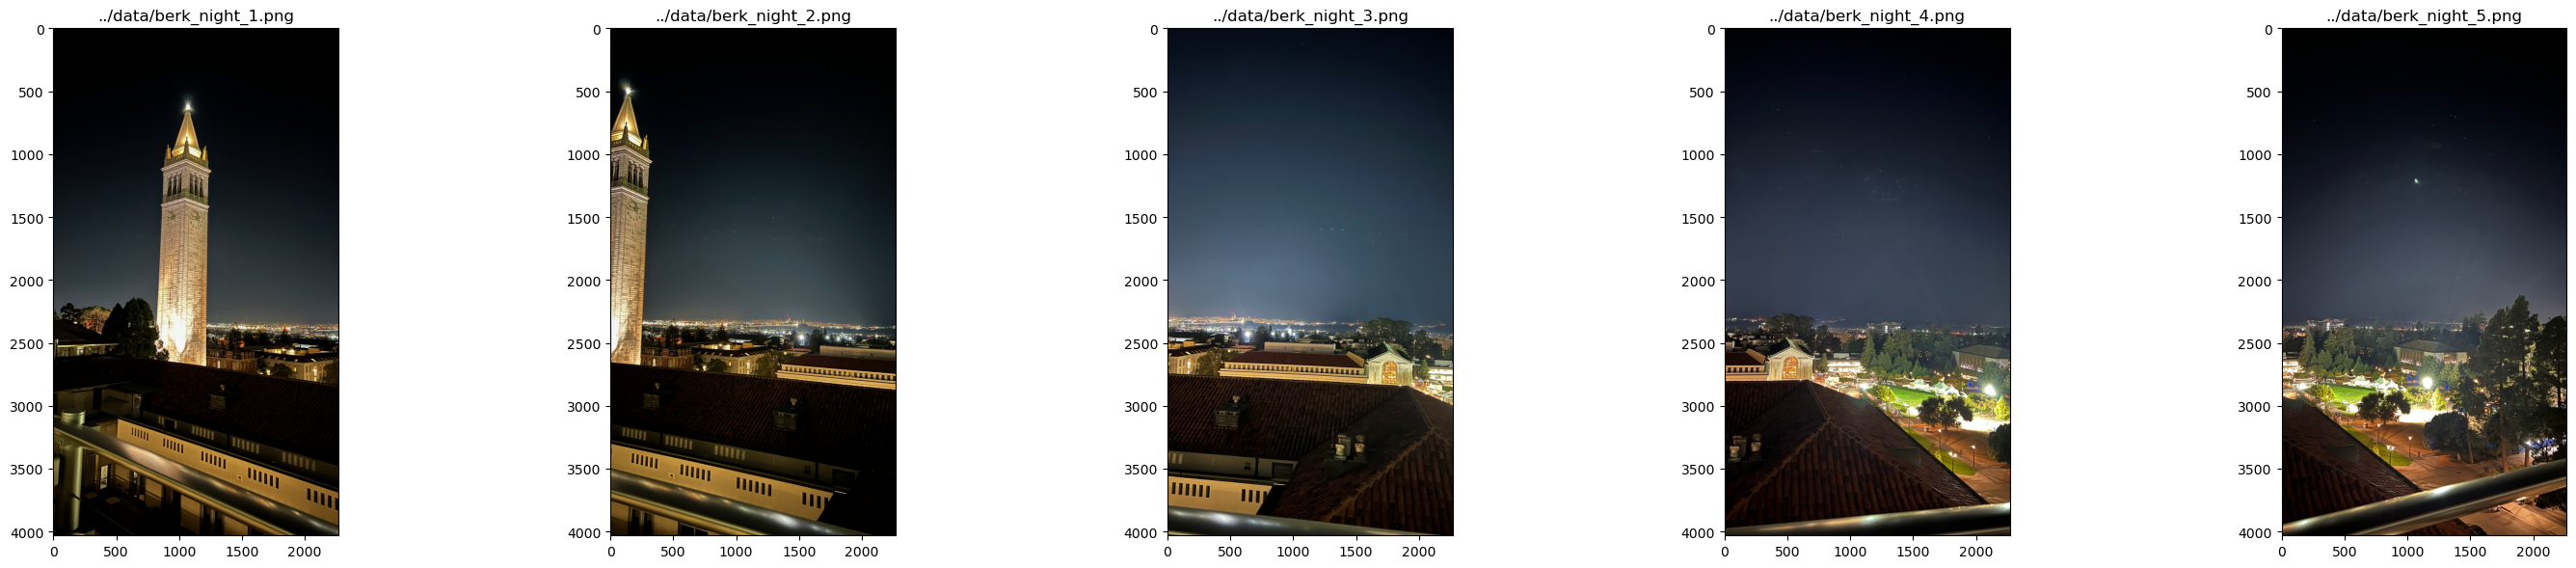

In [6]:
DisplayImages(ims, filenames, 6)

# Recovering Homographies
$$
p' = Hp
$$ 
Where H is a 3x3 matrix (with 8 degrees of freedom), p is a point in the original image, and p' is the point in the new image.
Will need to write a function that recovers the homography via a set of corresponding points $(p, p')$. 

`H = computeH(im1_pts, im2_pts)`

Where `im1_pts` and `im2_pts` are n by 2 matrices of corresponding points in the two images.

In order to solve for the entries of matrix `H` we will need to setup a linear system of n equations, which can be written as 
$$Ah = b$$ 
where $h$ is a vector of the 8 entries of `H`. More than 4 correspondances should be provided to produce an overdetermined system which can be solved using least squares. (This will be more stable than if we chose 4 correspondances and solved using a direct method.)

For the purposes of the first part of this project, I will manually determine the correspondancs using a tool like [GIMP](https://www.gimp.org/).

For `computeH()` I will probably use `np.linalg.lstsq()` or `scipy.optimize.least_squares()` or `scipy.optimize.nnls()` probably using a contraint on `h` to make it have magnitude of 1. As of right now I'm not entirely sure if I need to constrain it or not.

In [35]:
def computeH(im1_pts, im2_pts):
    """
    Inputs:
        im1_pts: nx2 matrix of points from image 1 (x,y).
        im2_pts: nx2 matrix of points from image 2 (x,y).
        n >= 4 
    Returns:
        H: 3x3 Homography matrix from image 1 to image 2.
    Strategy:
        A = [[x y 1 0 0 0 -x*x' -y*x']
             [0 0 0 x y 1 -x*y' -y*y']
             [          .            ]
             [    .     .       .    ]
             [  .       .         .  ]
             [.        ...          .]] 
        h = [a b c d e f g h]^T
        b = [x' y' ...]^T
        Solve Ah = b for h.
        Reshape to 3x3.
    """
    # Solve the linear system Ah = b
    A = np.zeros((2*im1_pts.shape[0], 8))
    b = np.zeros((2*im1_pts.shape[0], 1))
    for i in range(im1_pts.shape[0]):
        x1, y1 = im1_pts[i]
        x2, y2 = im2_pts[i]
        A[2*i,   :] = np.array([x1, y1, 1,  0,  0, 0, -x1*x2, -y1*x2])
        A[2*i+1, :] = np.array([ 0,  0, 0, x1, y1, 1, -x1*y2, -y1*y2])
        b[2*i,   :] = x2
        b[2*i+1, :] = y2
    h = np.linalg.lstsq(A, b, rcond=None)[0]
    h = np.append(h, 1)
    H = h.reshape((3,3))
    return H

In [36]:
# Test computeH
im1_pts = np.array([[1, 1], [1, 2], [2, 1], [2, 2]])
im2_pts = np.array([[2, 2], [2, 3], [3, 2], [3, 3]])
H = computeH(im1_pts, im2_pts)
H_inv = np.linalg.inv(H)
for i in range(im1_pts.shape[0]):
    assert np.allclose(H @ np.append(im1_pts[i], 1), np.append(im2_pts[i], 1))
    assert np.allclose(np.append(im1_pts[i], 1), H_inv @ np.append(im2_pts[i], 1))

# Manually get correspondences.
# For simplicity's sake, I will just stitch 2 images together for now.

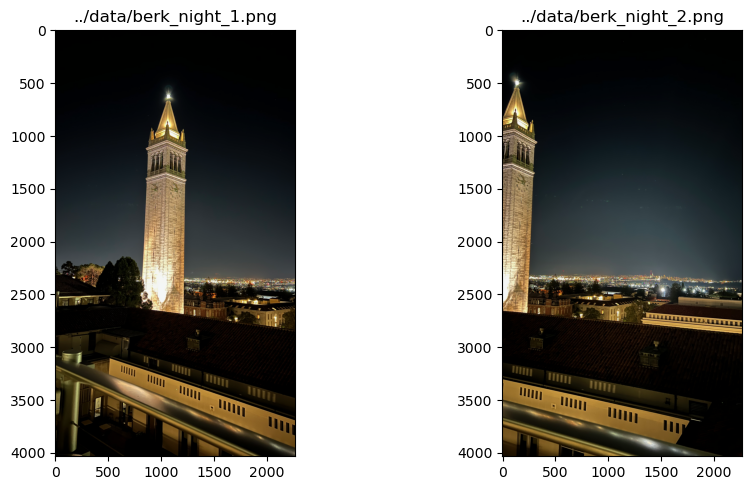

(4032, 2268, 3) (4032, 2268, 3)


In [9]:
DisplayImages(ims[:2], filenames[:2], 5)
im1, im2 = ims[:2]
print(im1.shape, im2.shape)

In [75]:
# (x,y) format (0,0) is top left
im1_pts = [
    [1075,  537], # very top of campinele
    [1057, 1040], # middle corner of ledge on campinele
    [1354, 3424], # top left corner of window to the left of white box
    [2086, 2759], # bottom right corner of bright window on wheeler
]
"""
    [2047, 3757], # bottom right corner of leftmost window of the the last row of windows on lower building
    [1656, 3529], # top right corner of 3rd window to the right of white box
    [1032, 3380], # bottom right corner of 1st window of row of windows 2nd to the left of the white box
    [1357, 2438], # bottom right corner of church tower
    [1244, 2663],
    [1239, 2912],
    [1367, 2938],
]
"""
"""
    [],
    [],
    [],
    [],
    [],
    [],
]
"""

'\n    [],\n    [],\n    [],\n    [],\n    [],\n    [],\n]\n'

In [76]:
# (x,y) format (0,0) is top left
im2_pts = [
    [148, 403],
    [116, 935],
    [358, 3421],
    [1097, 2706],
]
"""
    [1555, 3791],
    [663, 3491],
    [8, 3415],
    [400, 2416],
    [269, 2651],
    [254, 2907],
    [390, 2925],

] """
"""
    [],
    [],
    [],
    [],
    [],
]
"""

'\n    [],\n    [],\n    [],\n    [],\n    [],\n]\n'

# Test that the homography works

In [77]:
im1_pts = np.array(im1_pts)
im2_pts = np.array(im2_pts)
H = computeH(im1_pts, im2_pts)
print('H:\n',H)
H_inv = computeH(im2_pts, im1_pts)
print('H_inv:\n', H_inv)
for i in range(im1_pts.shape[0]):
    im1_pt = np.append(im1_pts[i], 1)
    im2_pt = np.append(im2_pts[i], 1)
    im1_pt_t = H @ im1_pt
    im1_pt_t = im1_pt_t / im1_pt_t[2]
    im2_pt_t = H_inv @ im2_pt
    im2_pt_t = im2_pt_t / im2_pt_t[2]
    print(f"i={i}, im1_pts[{i}]={im1_pt}, im2_pts[{i}]={im2_pt}")
    print(f"im1_pts[{i}] transformed by H    = {im1_pt_t}")
    print(f"im2_pts[{i}] transformd by H_inv = {im2_pt_t}")
    assert np.allclose(im1_pt_t, im2_pt)
    assert np.allclose(im2_pt_t, im1_pt)

H:
 [[ 1.09538008e+00 -2.72206109e-02 -1.00801150e+03]
 [ 7.34461928e-02  1.11097227e+00 -2.53745684e+02]
 [ 4.19286048e-05  2.94145982e-06  1.00000000e+00]]
H_inv:
 [[ 9.12040110e-01  1.98989796e-02  9.24396199e+02]
 [-6.89826086e-02  9.33309425e-01  1.67287976e+02]
 [-3.80376596e-05 -3.57962871e-06  1.00000000e+00]]
i=0, im1_pts[0]=[1075  537    1], im2_pts[0]=[148 403   1]
im1_pts[0] transformed by H    = [147.99999999 402.99999995   1.        ]
im2_pts[0] transformd by H_inv = [1.075e+03 5.370e+02 1.000e+00]
i=1, im1_pts[1]=[1057 1040    1], im2_pts[1]=[116 935   1]
im1_pts[1] transformed by H    = [115.99999998 934.99999999   1.        ]
im2_pts[1] transformd by H_inv = [1.057e+03 1.040e+03 1.000e+00]
i=2, im1_pts[2]=[1354 3424    1], im2_pts[2]=[ 358 3421    1]
im1_pts[2] transformed by H    = [3.580e+02 3.421e+03 1.000e+00]
im2_pts[2] transformd by H_inv = [1.354e+03 3.424e+03 1.000e+00]
i=3, im1_pts[3]=[2086 2759    1], im2_pts[3]=[1097 2706    1]
im1_pts[3] transformed by H   

# Warp one of the images to the other
## I will warp image 1 to image 2

In [88]:
# Remember how to do inverse warp
def inverse_warp(im, target_shape, im_pts, target_pts):
    """
    Inputs:
        im: 3 channel image
        target_shape: shape of the target image
        im_pts, target_pts: nx2 matrices of correspondences from image and target (x,y).
    Returns:
        im transformed by H
    """
    def get_interpolator(im):
        x_dim = np.arange(0, im.shape[1])
        y_dim = np.arange(0, im.shape[0])

        r_interpolator = RegularGridInterpolator((y_dim, x_dim), im[:,:,0], method='linear', bounds_error=False, fill_value=None)
        g_interpolator = RegularGridInterpolator((y_dim, x_dim), im[:,:,1], method='linear', bounds_error=False, fill_value=None)
        b_interpolator = RegularGridInterpolator((y_dim, x_dim), im[:,:,2], method='linear', bounds_error=False, fill_value=None)

        def interpolate_rgb(yx_coord):
            r = r_interpolator(yx_coord)
            g = g_interpolator(yx_coord)
            b = b_interpolator(yx_coord)
            return np.column_stack((r, g, b))
        
        return interpolate_rgb
    # Get the interpolator that will get the pixel values for our inverse coordinates.
    interpolate_rgb = get_interpolator(im)

    # Convert the points from (x,y) format to (y,x) format.


    # Compute the homography from target to im.
    H = computeH(target_pts, im_pts)
    print(f"H:\n{H}")

    # Calculate the size and shape of the resulting transformed image.
    original_bounds = np.array([[0, 0], [target_shape[1], target_shape[0]]])
    transformed_bounds = H @ np.column_stack((original_bounds, np.ones((2,1)))).T
    transformed_bounds = transformed_bounds / transformed_bounds[2] 
    transformed_bounds = transformed_bounds[:2].T
    print(f"original_bounds: \n{original_bounds}")
    print(f"transformed_bounds: \n{transformed_bounds}")
    print(f"transformed_bounds - original_bounds: \n{transformed_bounds - original_bounds}")
    transformed_im = np.zeros(target_shape)

    # Make an array of all the pixels in the target image.
    # Calculate the inverse coordinate and interpolate the RGB values from the original image.
    target_pixels = np.array([[y, x] for y in range(target_shape[0]) for x in range(target_shape[1])])
    target_pixels_h = np.vstack((target_pixels.T, np.ones(target_pixels.shape[0])))
    inverse_pixels = H @ target_pixels_h

    # Normalize homogenous coordinates.
    for pixel in inverse_pixels.T:
        pixel /= pixel[2]

    # Remove homogenous coordinate and take transpose to put in nx2 format that RegularGridInterpolator can use. 
    inverse_pixels = inverse_pixels[:2, :].T

    interpolated_pixels = interpolate_rgb(inverse_pixels)

    transformed_im[target_pixels[:, 0], target_pixels[:, 1]] = interpolated_pixels

    # Test by making a mask that is the inverse coordinates of the target image.
    return transformed_im

    # Get all of the pixels in the target image array as 2xN array of points
    # Append a row of all ones to the array to turn into homogeneous coordinates.
    # Compute the inverse transformation of the pixel array, elementwise.
    # Cut off the last row of the inverse pixels array to turn into cartesian coordinates.
    # Put the inverse coordinates into a format that RegularGridInterpolator can use.
    # Make a new array that contains the interpolated RGB values from the original image of the inverse pixels
    # Set the pixels in the transformed image to the interpolated values.
    # Remove homogenous coordinate
    # Clamp the values to be within the image

    pass

In [89]:
# Testing inverse_warp
warped_im = inverse_warp(ims[0], ims[1].shape, im1_pts, im2_pts)

H:
[[ 9.12040110e-01  1.98989796e-02  9.24396199e+02]
 [-6.89826086e-02  9.33309425e-01  1.67287976e+02]
 [-3.80376596e-05 -3.57962871e-06  1.00000000e+00]]
original_bounds: 
[[   0    0]
 [2268 4032]]
transformed_bounds: 
[[ 924.39619858  167.28797563]
 [3417.26266213 4196.54109707]]
transformed_bounds - original_bounds: 
[[ 924.39619858  167.28797563]
 [1149.26266213  164.54109707]]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<class 'numpy.ndarray'>


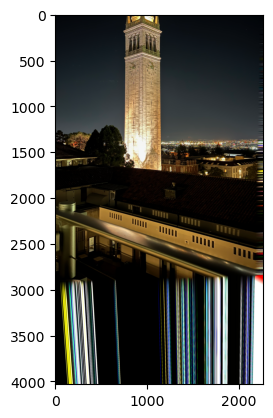

In [90]:
print(type(warped_im))
imshow(warped_im)

# Image Rectification

# Blend Images into Mosaic

# Most Important/Coolest thing I've learned from this part?